# Manual Feature Engineering

[Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is the process of creating new features (also called explanatory or predictor variables) out of an existing dataset to help a machine learning model train for a prediction problem. In many cases, the data is spread across numerous related tables linked by specific variables (known as keys). Because a machine learning model can only use a single table when training/predicting, feature engineering requires consolidating all the features in one table that has a single row for each observation with the columns containing the features. Once the data has been gathered into a single table, a machine learning model is trained on the training data and then assessed by making predictions on the hold-out testing data. Feature engineering is generally [considered the most important step of the machine learning pipeline](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf) because a model can only learn from the data it is given.

Traditionally, feature engineering is carried out by hand, often involving domain expertise to try and capture as many useful relationships as possible. Feature engineering can also be empirically driven, by relying on past features that have proven useful for other problems. It can also be done naively, by creating as many features as possible with no consideration beforehand of their physical relevance to the problem. Then, the features that are most useful are retained or built upon in subsequent iterations.  

While feature engineering is crucial to the success of a machine learning project, it can also be extremely tedious and time-consuming. Moreover, humans are limited both by time constraints and by creativity when it comes to designing new features. As a result, it is impossible to know when all the options for new features have been exhuasted and if the resulting set of features is as good as it could be. The ultimate dream technique in machine learning would be a method to automatically build hundreds or thousands of useful features from a set of related data tables. This technology would not replace the data scientist, but would allow here to overcome the inherent human limitations and spend more time on other important aspects of the machine learning pipeline such as prediction engineering or interpreting the model results. 

In this notebook, we will walk through the steps of manual feature engineering for a machine learning task. We will build domain knowledge features, new features based on those that have proved important in previous modeling, and by naive creating thousands of new features using statistical aggregations. 

## Problem and Dataset

The [Home Credit Default Risk competition](https://www.kaggle.com/c/home-credit-default-risk) currently running on Kaggle is a supervised classification task where the objective is to predict whether or not an applicant (known as a client) will default on loan. The data comprises socio-economic indicators for the clients, loan specific financial information, and comprehensive data on previous loans at Home Credit (the institution sponsoring the competition) and other credit bureaus. The metric for this competition is Receiver Operating Characteristic Area Under the Curve (ROC AUC). Submissions to the public leaderboard are ranked based on 10% of the testing data.

The Home Credit Default Risk dataset ([available for download](https://www.kaggle.com/c/home-credit-default-risk/data)) consists of seven tables of data:

* application_train/application_test: the main training/testing data for each client at Home Credit. The information includes both socioeconomic indicators for the client and loan-specific characteristics. Each loan has its own row and is uniquely identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 
* bureau: data concerning client's previous credits from other financial institutions (not Home Credit). Each previous credit has its own row in bureau, but one client in the application data can have multiple previous credits. The previous credits are uniquely identified by the feature `SK_ID_BUREAU`.
* bureau_balance: monthly balance data about the credits in bureau. Each row has information for one month about a previous credit and a single previous credit can have multiple rows. This is linked backed to the bureau loan data by `SK_ID_BUREAU` (not unique in this dataframe).
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each client in the application data can have multiple previous loans. Each previous application has one row in this dataframe and is uniquely identified by the feature `SK_ID_PREV`. 
* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans from the previous loan data. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows. This is linked backed to the previous loan data by `SK_ID_PREV` (not unique in this dataframe).
* credit_card_balance: monthly data about previous credit cards loans from the previous loan data. Each row is one month of a credit card balance, and a single credit card can have many rows. This is linked backed to the previous loan data by `SK_ID_PREV` (not unique in this dataframe).
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. This is linked backed to the previous loan data by `SK_ID_PREV` (not unique in this dataframe).

The image below shows the seven tables and the variables (keys) linking them:

![](../../images/kaggle_home_credit/home_credit_data.png)

Manual feature engineering will require extracting all of the data into a single table, which in this case will be the `application` table (known as `app`). New features can be made by manipulating columns from the original `application` data (such as dividing or subtracting two columns) or by using the children data tables. The children data tables must be grouped by a parent variable (such as `SK_ID_CURR`) and then aggregated for the parent. We will discuss child and parent tables shortly after we work with creating features from the main dataframe.  

Our first task will be to make features solely from the main dataframe `app`. It is possible to build a reasonably high-performance model from this data alone, but to get over the plateau of scores on the leaderboard requires using all of the data. 

In [120]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

RSEED = 50

We will join the training and testing data together to make sure that any operations we do to one set is repeated for the other set. The testing data can be extracted using `test = app[app["TARGET"].isnull()].copy()`.

We will handle the categorical variables by __one-hot encoding__ them. The trainnig and testing data must be aligned after one-hot encoding to get only the same features in both datasets.

In [121]:
app_train = pd.read_csv('../../data/kaggle_home_credit/application_train.csv')
app_test = pd.read_csv('../../data/kaggle_home_credit/application_test.csv')

train_ids = list(app_train['SK_ID_CURR'])
test_ids = list(app_test['SK_ID_CURR'])

# One Hot Encode
app_train, app_test = pd.get_dummies(app_train), pd.get_dummies(app_test)
app_test['TARGET'] = np.nan

# Align on the columns
app_train, app_test = app_train.align(app_test, axis = 1, join = 'inner')
original_features = list(app_train.columns)
original_features.remove('TARGET')
original_features.remove('SK_ID_CURR')

# Combine train/test into one dataset
app = app_train.append(app_test, sort=False)

print('There are originally {} features.'.format(app.shape[1] - 2))

There are originally 241 features.


(One of the columns is the key, `SK_ID_CURR`, and one of the columns is the label, `TARGET`.)

### Baseline Model 

Before doing any feature engineering, it's important to establish a __baseline performance measure__. This will let us get a sense if feature engineering improves the model, and by how much. Throughtout this project, we will use the [Gradient Boosting Machine](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/), in particular, the implementation from the [LightGBM library](http://lightgbm.readthedocs.io/en/latest/). For a baseline model, we will use the default hyperparameters values and the initial set of features from the `app` data. The number of estimators will be selected using early stopping for 100 rounds with 5-fold cross validation. This means that the number of estimators trained (`n_estimators` or `num_boost_rounds`) will be determined by the number of estimators that yields the highest performance metric as determined by 5-fold cross validation. Early stopping alleviates the need to choose the number of estimators and is an effective regularization technique for preventing overfitting to the training data.

In [122]:
import lightgbm as lgb

# Extract the labels
train_labels = np.array(app_train['TARGET'].astype(np.int32)).reshape((-1, ))
train = app_train.drop(columns = ['TARGET', 'SK_ID_CURR'])
test = app_test.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Create a  lgb training set
train_set = lgb.Dataset(train, label = train_labels)

# Find default hyperparameters
model = lgb.LGBMClassifier()
params = model.get_params()

# Number of estimators will be selected through early stopping
del params['n_estimators'], params['silent']

# Early stoppping with 5 fold cross validation
cv_results = lgb.cv(params, train_set, num_boost_round = 10000, metrics = 'auc', 
                    early_stopping_rounds = 100, seed = RSEED, nfold = 5)

print('Baseline Cross Validation ROC AUC: {:.5f} with std: {:.5f}.'.format(cv_results['auc-mean'][-1],
                                                                           cv_results['auc-stdv'][-1]))

print('Number of estimators trained: {}'.format(len(cv_results['auc-mean'])))

Baseline Cross Validation ROC AUC: 0.75565 with std: 0.00604.
Number of estimators trained: 141


In [123]:
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), random_state=RSEED)
model.fit(train, train_labels)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=141,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [126]:
def make_submission(model, test):
    
    # Make predictions on the testing data
    preds = model.predict_proba(test)[:, 1]
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 
                                'TARGET': preds})
    
    return submission

We can then use this model to make predictions on the testing data and submit to the compeition for scoring. 

In [127]:
submission_baseline = make_submission(model, test)
submission_baseline.to_csv('../../data/kaggle_home_credit/submission_baseline.csv', index = False)

# Domain Knowledge Features

A large part of manual feature engineering involves trying to use domain knowledge in order to build features that are relevant for a particular problem. This may mean consulting experts, or by reading through the relevant literature to find features that are applicable in a given field. For the Kaggle Home Credit Default Risk competition, [many kernels ](https://www.kaggle.com/c/home-credit-default-risk/kernels) have been developed by a community of thousands of data scientists documenting useful features that have been constructed both by using domain knowledge and through trial and error. This section relies on heavily on a number of kernels, most notably

* https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features
* https://www.kaggle.com/dromosys/fork-of-fork-lightgbm-with-simple-features-cee847

As an example of a feature from domain knowledge, we can find the interest rate of a loan. Although not given in the original data, this can be calculated by dividing the loan annuity,`AMT_ANNUITY`, by the total amount of the loan `AMT_CREDIT`. This may be useful because a higher risk loan will probably have a higher interest rate because it is more likely to default. 

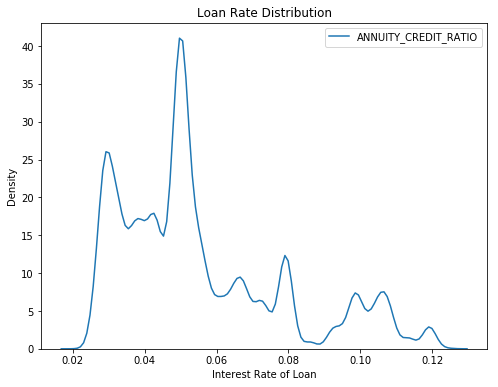

In [10]:
# Replace the anomalous values
app = app.replace({365243: np.nan})

# New features
app['ANNUITY_CREDIT_RATIO'] = app['AMT_ANNUITY'] / app['AMT_CREDIT'] 

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(app['ANNUITY_CREDIT_RATIO'].dropna());
plt.title('Loan Rate Distribution'); plt.xlabel('Interest Rate of Loan'); plt.ylabel('Density');

To try and get a sense if this feature will be useful, we can show the kde plot by whether or not the loan was repaid (this only applies for the training data). We can also use the Pearson correlation coefficient to guage a variables association with the target. Although the correlation coefficient only measures linear relationships, it can serve as an approximation for which features may be important for a prediction problem. 

In [16]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    df = df.reset_index(drop = True).copy()
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name].dropna(), label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name].dropna(), label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

The correlation between ANNUITY_CREDIT_RATIO and the TARGET is 0.0127
Median value for loan that was not repaid = 0.0500
Median value for loan that was repaid =     0.0500


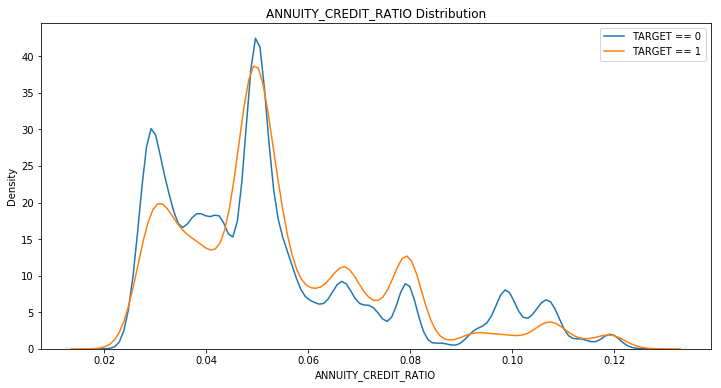

In [18]:
kde_target('ANNUITY_CREDIT_RATIO', app[app['TARGET'].notnull()])

This variable does not appear to show much difference between those who repaid the loan and those who did not. Nonetheless, it is not possible to say if this variable will be "important" because there could be complex low-level interactions with other variables that render it important.

We can continue with this domain and literature reliant process, trying to create new features that we think are important based on the problem. For example, we can add features that compare the total credit amount `AMT_CREDIT` to the total income, `AMT_INCOME_TOTAL` or calculate the ratio of how long a client has been employed `DAYS_EMPLOYED` to their age `DAYS_BIRTH` (these values are recorded relative to the current application so are negative). These are all features that have been developed by other community data scientists on Kaggle and are re-created here with their permission. 

In [19]:
app['CREDIT_INCOME_RATIO'] = app['AMT_CREDIT'] / app['AMT_INCOME_TOTAL']
app['EMPLOYED_BIRTH_RATIO'] = app['DAYS_EMPLOYED'] / app['DAYS_BIRTH']

In [20]:
app['CREDIT_INCOME_RATIO'].describe()

count    356255.000000
mean          3.849476
std           2.635035
min           0.004808
25%           2.000000
50%           3.158857
75%           5.000000
max          84.736842
Name: CREDIT_INCOME_RATIO, dtype: float64

The correlation between EMPLOYED_BIRTH_RATIO and the TARGET is -0.0680
Median value for loan that was not repaid = 0.0935
Median value for loan that was repaid =     0.1216


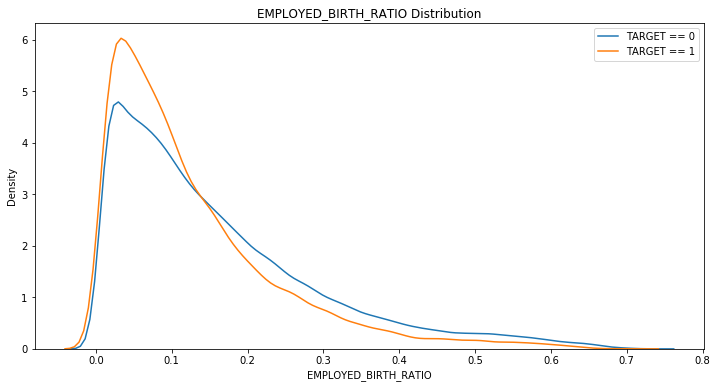

In [21]:
kde_target('EMPLOYED_BIRTH_RATIO', app[app['TARGET'].notnull()])

### Model Importance Feature Engineering

We can also use modeling results to construct new features. For example, when building a model using the Gradient Boosting Machine (as implemented in LightGBM), we can examine the feature importances from the model. We can then use the features considered most important by the model to construct new features that hopefully capture additional information from these features. 

We can use the feature importances from the default model.

In [99]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

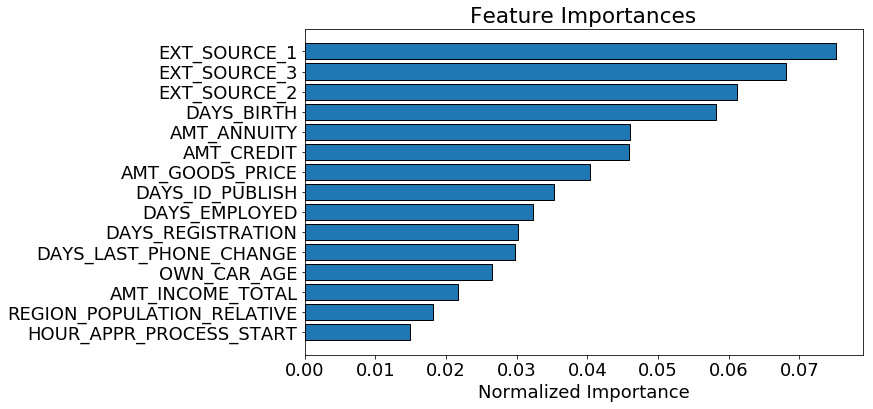

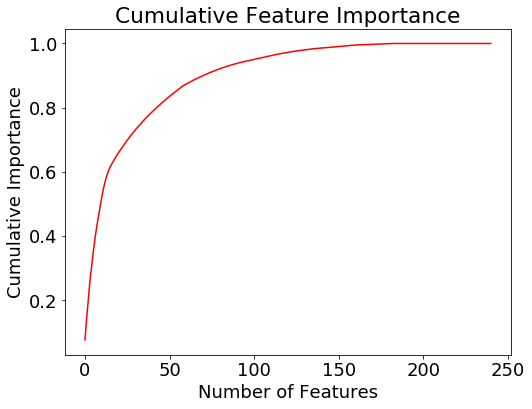

71 features required for 0.90 of cumulative importance


,index,feature,importance,importance_normalized,cumulative_importance
0,27,EXT_SOURCE_1,318,0.075177,0.075177
1,29,EXT_SOURCE_3,288,0.068085,0.143262
2,28,EXT_SOURCE_2,259,0.061229,0.204492
3,6,DAYS_BIRTH,246,0.058156,0.262648
4,3,AMT_ANNUITY,195,0.046099,0.308747
5,2,AMT_CREDIT,194,0.045863,0.354610
6,4,AMT_GOODS_PRICE,171,0.040426,0.395035
7,9,DAYS_ID_PUBLISH,149,0.035225,0.430260
8,7,DAYS_EMPLOYED,137,0.032388,0.462648
9,8,DAYS_REGISTRATION,128,0.030260,0.492908


In [128]:
feature_importances = pd.DataFrame({'feature': list(train.columns), 
                                    'importance': model.feature_importances_})

norm_fi = plot_feature_importances(feature_importances)
norm_fi.head(10)

Based on the features that are most important, we can come up with our own new features. The `EXT_SOURCE_` features are already a combination of numerous unknown factors (these are an external score), but we can use them to come up with our own features given that they are very important to the model. 

In [23]:
app['SOURCE_PRODUCT'] = app['EXT_SOURCE_1'] * app['EXT_SOURCE_2'] * app['EXT_SOURCE_3']
app['SOURCE_MEAN'] = app[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)

The correlation between SOURCE_MEAN and the TARGET is -0.2221
Median value for loan that was not repaid = 0.3991
Median value for loan that was repaid =     0.5338


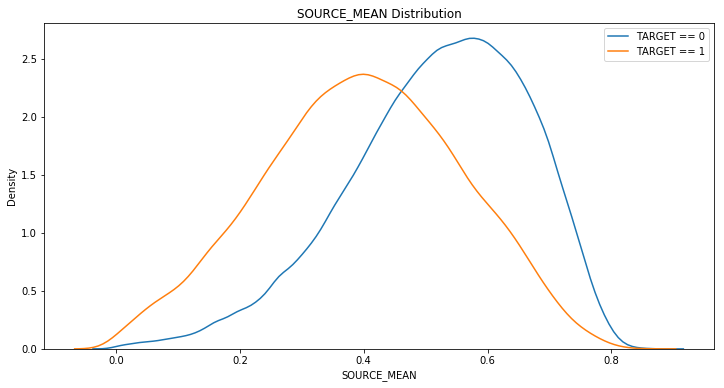

In [24]:
kde_target('SOURCE_MEAN', app[app['TARGET'].notnull()])

This feature looks like it may be important given the significant difference in the distribution between loans that were repaid and those that were not. 

We will make several more features from the top 5 most important. 

In [28]:
app['DAYS_SOURCE_MEAN'] = app['DAYS_BIRTH'] / app['SOURCE_MEAN'] 
app['ANNUITY_SOURCE_MEAN'] = app['AMT_ANNUITY'] / app['SOURCE_MEAN']
app['AMT_GOODS_PRICE_AMT_CREDIT'] = app['AMT_GOODS_PRICE'] / app['AMT_CREDIT']
app['DAYS_EMPLOYED_DAYS_ID_PUBLISH'] = app['DAYS_EMPLOYED'] / app['DAYS_ID_PUBLISH']

The correlation between AMT_GOODS_PRICE_AMT_CREDIT and the TARGET is -0.0654
Median value for loan that was not repaid = 0.8732
Median value for loan that was repaid =     0.8938


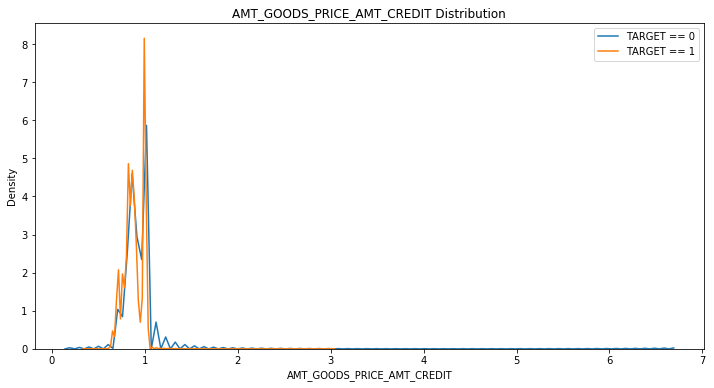

In [34]:
kde_target('AMT_GOODS_PRICE_AMT_CREDIT', app[app['TARGET'].notnull()])

We can also calculate the correlation of all the features with the target to see if there are any relationships. Although this is not the best measure for the importance of a feature, it can be an approximation. 

In [35]:
# Calculate all correlations
corrs = app[app['TARGET'].notnull()].corr().sort_values('TARGET')

In [36]:
# Most negative correlations
corrs['TARGET'].dropna().head()

SOURCE_MEAN      -0.222052
SOURCE_PRODUCT   -0.188552
EXT_SOURCE_3     -0.178919
EXT_SOURCE_2     -0.160472
EXT_SOURCE_1     -0.155317
Name: TARGET, dtype: float64

In [37]:
# Most positive correlations
corrs['TARGET'].tail()

REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

### Testing New Features

After building the new features, we can make another model in order to determine if the features have improved the cross validation ROC AUC or the competition score. Again, we will use early stopping with 5-fold cross validation to determine the number of estimators to train. 

In [38]:
app_train = app[app['TARGET'].notnull()].copy()
train = pd.get_dummies(app_train.drop(columns = ['TARGET', 'SK_ID_CURR']))


# Create a training set
train_set = lgb.Dataset(train, label = train_labels)

# Find default hyperparameters
model = lgb.LGBMClassifier()
params = model.get_params()

# Number of estimators will be selected through early stopping
del params['n_estimators'], params['silent']

cv_results = lgb.cv(params, train_set, num_boost_round = 10000, metrics = 'auc', 
                    early_stopping_rounds = 100, seed = RSEED, nfold = 5)

print('Baseline Cross Validation ROC AUC: {:.5f} with std: {:.5f}.'.format(cv_results['auc-mean'][-1],
                                                                           cv_results['auc-stdv'][-1]))
print('Number of estimators trained: {}'.format(len(cv_results['auc-mean'])))

/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:661: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Baseline Cross Validation ROC AUC: 0.76282 with std: 0.00642.
Number of estimators trained: 189


In [39]:
# Fit a model on the data to get the feature importances
model = lgb.LGBMClassifier(random_state=RSEED, n_estimators = len(cv_results['auc-mean']))
model.fit(train, train_labels)

feature_importances = pd.DataFrame({'feature': list(train.columns), 
                                    'importance': model.feature_importances_})

feature_importances.sort_values('importance', ascending = False, inplace = True)
feature_importances.head(10)

,feature,importance
241,CREDIT_ANNUITY_RATIO,435
29,EXT_SOURCE_3,244
27,EXT_SOURCE_1,210
6,DAYS_BIRTH,209
246,SOURCE_MEAN,182
28,EXT_SOURCE_2,180
9,DAYS_ID_PUBLISH,169
249,AMT_GOODS_PRICE_AMT_CREDIT,167
8,DAYS_REGISTRATION,159
7,DAYS_EMPLOYED,150


Several of the features we built make it into the top 10 most important. This could indicate they are actually useful for the problem, or this could be overfitting to the testing set. The performance of the model did increase in cross validation, which indicates these features may be useful to the model. 

# Information from Other Tables

The few features we made from domain knowledge were all derived from a single source of data, the `app` dataframe. That leaves us with six other tables that we somehow need to incorporate into the final dataset for training and testing. 

## Table Relationships

To use the other tables, we will have to take advantage of table relationships. The easiest way to think of these relationships is the analogy between parent and child. A one-to-many relationship is a parent-to-child because for each parent individual, there can be many children. For example, the `bureau` data is a child of the `app` data because for each client in `app`, there may be many previous loans at other institutions. 

In [41]:
bureau = pd.read_csv('../../data/kaggle_home_credit/bureau.csv')
bureau.head(10)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.00,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.00,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.00,71017.38,108982.62,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.80,42103.80,0.00,0.0,Consumer credit,-22,NaN
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.00,0.00,0.0,Consumer credit,-1710,NaN
8,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.0,0,103007.70,0.00,0.00,0.0,Consumer credit,-840,NaN
9,162297,5714471,Active,currency 1,-1146,0,-484.0,NaN,0.0,0,4500.00,0.00,0.00,0.0,Credit card,-690,NaN


The first client has 7 loans in this data indicating seven children for the single parent client. These two tables are related by a variable, in this case the `SK_ID_CURR`. For these tables, the variable (which we will call the parent variable) is named the same in both tables, but this is not necessarily always the case. The parent variable must be unique in the parent dataframe, as with this case, where each client has one id that is not repeated. 

A child dataframe can in turn be the parent of a different child much like in a real family. This makes the original parent the grandparent of the child's children. For example, the `bureau_balance` dataframe has monthly information about each loan in `bureau`. This makes `bureau` the parent of `bureau_balance` and `app` the grandparent. `bureau` is linked to `bureau_balance` by `SK_ID_BUREAU`, the parent variable for `bureau` which uniquely idenfitifies each previous loan. 

### Grouping and Aggregation

In order to incorporate information from a child table in a parent, we have to group the children for each parent and then calculate aggregation statistics. We will see how to do this shortly, but an example is to group all the loans for a single client, and then calculate the average loan amount. This average would then form a single new column in the parent dataframe. We have to use aggregations because the parent dataframe can only have one row per parent individual and so we have to capture all the information about the children in a single number (we can use multiple aggregations, but each one outputs only a single number). 

When we get to the grandchildren tables, we will have to group and aggregate these twice: first at the parent level and then at the grandparent level. For example, if we have monthly information about each loan where each client may have many previous loans, then we have to aggregate the monthly information at the loan level and then aggregate the loan level information at the client level. We could calculate the average monthly payment per loan, and then for all of a client's loans, calculate the maximum average monthly payment. This stat would be a single column in the final training dataframe. 

# Numeric Aggregations

First, we will start by aggregating the numeric variables in the children data frames. As one example of a feature we can make from a child table, we can count the number of previous loans for each client.

In [42]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


We would then have to join this to the main `app` dataframe on the `SK_ID_CURR` to get the information for training. 

The general process above can be applied to all the numeric information using several aggregations. The code below finds the `count`, `mean`, `max`, `min`, and `sum` of all the numeric columns in the `bureau` dataframe.

In [46]:
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR').agg(['count', 'mean', 'max', 'min', 'sum'])
bureau_agg.head()

DAYS_CREDIT                               CREDIT_DAY_OVERDUE       \
                 count         mean  max   min   sum              count mean   
SK_ID_CURR                                                                     
100001               7  -735.000000  -49 -1572 -5145                  7  0.0   
100002               8  -874.000000 -103 -1437 -6992                  8  0.0   
100003               4 -1400.750000 -606 -2586 -5603                  4  0.0   
100004               2  -867.000000 -408 -1326 -1734                  2  0.0   
100005               3  -190.666667  -62  -373  -572                  3  0.0   

                         ...    DAYS_CREDIT_UPDATE                         \
           max min sum   ...                 count        mean  max   min   
SK_ID_CURR               ...                                                
100001       0   0   0   ...                     7  -93.142857   -6  -155   
100002       0   0   0   ...                     8 -499.875000   -7 -1185   
100003       0   0   0   ...                     4 -816.000000  -43 -2131   
100004       0   0   0   ...                     2 -532.000000 -382  -682   
100005       0   0   0   ...                     3  -54.333333  -11  -121   

                 AMT_ANNUITY                                      
             sum       count         mean      max  min      sum  
SK_ID_CURR                                                        
100001      -652           7  3545.357143  10822.5  0.0  24817.5  
100002     -3999           7     0.000000      0.0  0.0      0.0  
100003     -3264           0          NaN      NaN  NaN      0.0  
100004     -1064           0          NaN      NaN  NaN      0.0  
100005      -163           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 60 columns]

Now we should rename the columns so we can better keep track of what they represent. 

In [47]:
# New column names
columns = []
# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1]:
            # Make a new column name for the variable and stat
            columns.append('BUREAU_%s_%s' % (var, stat))
            
            
bureau_agg.columns = columns
bureau_agg.head()

,BUREAU_DAYS_CREDIT_count,BUREAU_DAYS_CREDIT_mean,BUREAU_DAYS_CREDIT_max,BUREAU_DAYS_CREDIT_min,BUREAU_DAYS_CREDIT_sum,BUREAU_CREDIT_DAY_OVERDUE_count,BUREAU_CREDIT_DAY_OVERDUE_mean,BUREAU_CREDIT_DAY_OVERDUE_max,BUREAU_CREDIT_DAY_OVERDUE_min,BUREAU_CREDIT_DAY_OVERDUE_sum,...,BUREAU_DAYS_CREDIT_UPDATE_count,BUREAU_DAYS_CREDIT_UPDATE_mean,BUREAU_DAYS_CREDIT_UPDATE_max,BUREAU_DAYS_CREDIT_UPDATE_min,BUREAU_DAYS_CREDIT_UPDATE_sum,BUREAU_AMT_ANNUITY_count,BUREAU_AMT_ANNUITY_mean,BUREAU_AMT_ANNUITY_max,BUREAU_AMT_ANNUITY_min,BUREAU_AMT_ANNUITY_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


We can take this process and put it in a function that can then be applied to any dataset. The following function aggregates all the numeric variables in a child dataframe at the parent level. That is, for each parent, gather together (group) all of their children, and calculate the aggregations statistics across the children. The function also removes any columns that share the exact same values (which might happen using `count`). 

In [54]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

In [55]:
bureau_agg = agg_numeric(bureau, 'SK_ID_CURR', 'BUREAU')
bureau_agg.head()

,BUREAU_DAYS_CREDIT_sum,BUREAU_DAYS_ENDDATE_FACT_sum,BUREAU_DAYS_CREDIT_min,BUREAU_DAYS_CREDIT_ENDDATE_min,BUREAU_DAYS_ENDDATE_FACT_min,BUREAU_DAYS_ENDDATE_FACT_mean,BUREAU_DAYS_CREDIT_mean,BUREAU_DAYS_CREDIT_UPDATE_sum,BUREAU_DAYS_ENDDATE_FACT_max,BUREAU_DAYS_CREDIT_UPDATE_min,...,BUREAU_AMT_CREDIT_SUM_DEBT_mean,BUREAU_AMT_CREDIT_SUM_min,BUREAU_AMT_CREDIT_SUM_mean,BUREAU_AMT_CREDIT_SUM_DEBT_max,BUREAU_AMT_CREDIT_SUM_max,BUREAU_AMT_CREDIT_SUM_DEBT_sum,BUREAU_AMT_CREDIT_SUM_sum,BUREAU_AMT_CREDIT_MAX_OVERDUE_min,BUREAU_AMT_CREDIT_MAX_OVERDUE_mean,BUREAU_AMT_CREDIT_MAX_OVERDUE_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-5145,-3302.0,-1572,-1329.0,-1328.0,-825.500000,-735.000000,-652,-544.0,-155,...,85240.928571,85500.0,207623.571429,373239.0,378000.0,596686.5,1453365.000,NaN,NaN,NaN
100002,-6992,-4185.0,-1437,-1072.0,-1185.0,-697.500000,-874.000000,-3999,-36.0,-1185,...,49156.200000,0.0,108131.945625,245781.0,450000.0,245781.0,865055.565,0.0,1681.029,5043.645
100003,-5603,-3292.0,-2586,-2434.0,-2131.0,-1097.333333,-1400.750000,-3264,-540.0,-2131,...,0.000000,22248.0,254350.125000,0.0,810000.0,0.0,1017400.500,0.0,0.000,0.000
100004,-1734,-1065.0,-1326,-595.0,-683.0,-532.500000,-867.000000,-1064,-382.0,-682,...,0.000000,94500.0,94518.900000,0.0,94537.8,0.0,189037.800,0.0,0.000,0.000
100005,-572,-123.0,-373,-128.0,-123.0,-123.000000,-190.666667,-163,-123.0,-121,...,189469.500000,29826.0,219042.000000,543087.0,568800.0,568408.5,657126.000,0.0,0.000,0.000


We can then apply this function to the other child of `application`, the `previous` data which has information on each client's previous loans at Home Credit (as opposed to credits at other financial institutions found in `bureau`).
The resulting dataframe can then be joined to the `app` dataframe using the parent variable, `SK_ID_CURR`.

In [56]:
previous = pd.read_csv('../../data/kaggle_home_credit/previous_application.csv')
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'PREVIOUS')
previous_agg.head()

,PREVIOUS_DAYS_DECISION_sum,PREVIOUS_DAYS_DECISION_min,PREVIOUS_DAYS_DECISION_mean,PREVIOUS_DAYS_DECISION_max,PREVIOUS_DAYS_FIRST_DUE_sum,PREVIOUS_DAYS_FIRST_DUE_min,PREVIOUS_DAYS_FIRST_DUE_mean,PREVIOUS_DAYS_FIRST_DUE_max,PREVIOUS_DAYS_LAST_DUE_sum,PREVIOUS_DAYS_LAST_DUE_min,...,PREVIOUS_DAYS_FIRST_DRAWING_min,PREVIOUS_DAYS_FIRST_DRAWING_mean,PREVIOUS_DAYS_FIRST_DRAWING_max,PREVIOUS_DAYS_FIRST_DRAWING_sum,PREVIOUS_RATE_INTEREST_PRIMARY_min,PREVIOUS_RATE_INTEREST_PRIMARY_mean,PREVIOUS_RATE_INTEREST_PRIMARY_max,PREVIOUS_RATE_INTEREST_PRIVILEGED_min,PREVIOUS_RATE_INTEREST_PRIVILEGED_mean,PREVIOUS_RATE_INTEREST_PRIVILEGED_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1740,-1740,-1740.0,-1740,-1709.0,-1709.0,-1709.000000,-1709.0,-1619.0,-1619.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100002,-606,-606,-606.0,-606,-565.0,-565.0,-565.000000,-565.0,-25.0,-25.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100003,-3915,-2341,-1305.0,-746,-3823.0,-2310.0,-1274.333333,-716.0,-3163.0,-1980.0,...,365243.0,365243.0,365243.0,1095729.0,NaN,NaN,NaN,NaN,NaN,NaN
100004,-815,-815,-815.0,-815,-784.0,-784.0,-784.000000,-784.0,-724.0,-724.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100005,-1072,-757,-536.0,-315,-706.0,-706.0,-706.000000,-706.0,-466.0,-466.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN


# Categorical Variables

The categorical variables from the children tables also need to be incorporated into the main data. With the application data, we one-hot encoded the variables and then used these directly as features. For the children data tables, we can take a similar approach but with an added aggregation step after one-hot encoding to create one row for each parent. 

As an example, consider the `bureau` dataframe.

In [57]:
bureau_ids = bureau['SK_ID_CURR'].copy()

# Select only the categorical columns
bureau_categorical = bureau.select_dtypes('object').copy()
bureau_categorical = pd.get_dummies(bureau_categorical)
bureau_categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The one-hot-encoded data is now all numeric which means we can use the grouping and aggregating functions as demonstrated earlier. However, here it does not make sense to find the `min` and `max` since these will just be 0 and 1 for binary variables.

In [58]:
bureau_categorical['SK_ID_CURR'] = bureau_ids

# Grouping and aggregating the one hot encoded data
bureau_categorical = bureau_categorical.groupby('SK_ID_CURR').agg(['sum', 'count', 'mean'])

column_names = []
    
# Iterate through the columns in level 
for var in bureau_categorical.columns.levels[0]:
    # Iterate through the stats in level 1
    for stat in ['sum', 'count', 'mean']:
        # Make a new column name
        column_names.append('%s_%s_%s' % ('BUREAU', var, stat))
            
bureau_categorical.columns = column_names
bureau_categorical.head()

,BUREAU_CREDIT_ACTIVE_Active_sum,BUREAU_CREDIT_ACTIVE_Active_count,BUREAU_CREDIT_ACTIVE_Active_mean,BUREAU_CREDIT_ACTIVE_Bad debt_sum,BUREAU_CREDIT_ACTIVE_Bad debt_count,BUREAU_CREDIT_ACTIVE_Bad debt_mean,BUREAU_CREDIT_ACTIVE_Closed_sum,BUREAU_CREDIT_ACTIVE_Closed_count,BUREAU_CREDIT_ACTIVE_Closed_mean,BUREAU_CREDIT_ACTIVE_Sold_sum,...,BUREAU_CREDIT_TYPE_Mobile operator loan_mean,BUREAU_CREDIT_TYPE_Mortgage_sum,BUREAU_CREDIT_TYPE_Mortgage_count,BUREAU_CREDIT_TYPE_Mortgage_mean,BUREAU_CREDIT_TYPE_Real estate loan_sum,BUREAU_CREDIT_TYPE_Real estate loan_count,BUREAU_CREDIT_TYPE_Real estate loan_mean,BUREAU_CREDIT_TYPE_Unknown type of loan_sum,BUREAU_CREDIT_TYPE_Unknown type of loan_count,BUREAU_CREDIT_TYPE_Unknown type of loan_mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,7,0.428571,0,7,0.0,4,7,0.571429,0,...,0.0,0,7,0.0,0,7,0.0,0,7,0.0
100002,2,8,0.250000,0,8,0.0,6,8,0.750000,0,...,0.0,0,8,0.0,0,8,0.0,0,8,0.0
100003,1,4,0.250000,0,4,0.0,3,4,0.750000,0,...,0.0,0,4,0.0,0,4,0.0,0,4,0.0
100004,0,2,0.000000,0,2,0.0,2,2,1.000000,0,...,0.0,0,2,0.0,0,2,0.0,0,2,0.0
100005,2,3,0.666667,0,3,0.0,1,3,0.333333,0,...,0.0,0,3,0.0,0,3,0.0,0,3,0.0


The process above will also be incorporated into a function that can be used with any child dataframe. It has the same inputs as `agg_numeric` but will deal with only the categorical variables. 

In [61]:
def agg_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [62]:
bureau_agg_cat = agg_categorical(bureau, 'SK_ID_CURR', 'BUREAU')
bureau_agg_cat.head()

,BUREAU_CREDIT_TYPE_Mobile operator loan_mean,BUREAU_CREDIT_TYPE_Mobile operator loan_sum,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean,BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_sum,BUREAU_CREDIT_ACTIVE_Bad debt_mean,BUREAU_CREDIT_ACTIVE_Bad debt_sum,BUREAU_CREDIT_TYPE_Interbank credit_mean,BUREAU_CREDIT_TYPE_Interbank credit_sum,BUREAU_CREDIT_TYPE_Real estate loan_mean,BUREAU_CREDIT_TYPE_Real estate loan_sum,...,BUREAU_CREDIT_TYPE_Credit card_sum,BUREAU_CREDIT_ACTIVE_Active_mean,BUREAU_CREDIT_ACTIVE_Closed_mean,BUREAU_CREDIT_TYPE_Consumer credit_mean,BUREAU_CREDIT_CURRENCY_currency 1_mean,BUREAU_CREDIT_ACTIVE_Active_sum,BUREAU_CREDIT_ACTIVE_Closed_sum,BUREAU_CREDIT_TYPE_Consumer credit_sum,BUREAU_CREDIT_CURRENCY_currency 1_sum,BUREAU_CREDIT_ACTIVE_Active_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,0,0.428571,0.571429,1.000000,1.0,3,4,7,7,7
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,4,0.250000,0.750000,0.500000,1.0,2,6,4,8,8
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,2,0.250000,0.750000,0.500000,1.0,1,3,2,4,4
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,0,0.000000,1.000000,1.000000,1.0,0,2,2,2,2
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1,0.666667,0.333333,0.666667,1.0,2,1,2,3,3


The results from the two `agg_` functions can be merged with each other on the parent id (`SK_ID_CURR`). This dataframe can then be merged with the parent dataframe. It will have one row for every unique observation of the parent. 

We can put these steps together into a function that will handle a child dataframe. The function will take care of both the numeric and categorical variables and will return the result of merging the two dataframes. 

In [65]:
import gc

def agg_child(df, parent_var, df_name):
    """Aggregate a child dataframe for each observation of the parent."""
    
    # Numeric and then categorical
    df_agg = agg_numeric(df, parent_var, df_name)
    df_agg_cat = agg_categorical(df, parent_var, df_name)
    
    # Merge on the parent variable
    df_info = df_agg.merge(df_agg_cat, on = parent_var, how = 'outer')
    
    # Remove any columns with duplicate values
    _, idx = np.unique(df_info, axis = 1, return_index = True)
    df_info = df_info.iloc[:, idx]
    
    # memory management
    gc.enable()
    del df_agg, df_agg_cat
    gc.collect()
    
    return df_info

In [66]:
bureau_info = agg_child(bureau, 'SK_ID_CURR', 'BUREAU')
bureau_info.head()

,BUREAU_DAYS_CREDIT_sum,BUREAU_DAYS_ENDDATE_FACT_sum,BUREAU_DAYS_CREDIT_min,BUREAU_DAYS_CREDIT_ENDDATE_min,BUREAU_DAYS_ENDDATE_FACT_min,BUREAU_DAYS_ENDDATE_FACT_mean,BUREAU_DAYS_CREDIT_mean,BUREAU_DAYS_CREDIT_UPDATE_sum,BUREAU_DAYS_ENDDATE_FACT_max,BUREAU_DAYS_CREDIT_UPDATE_min,...,BUREAU_AMT_CREDIT_SUM_DEBT_mean,BUREAU_AMT_CREDIT_SUM_min,BUREAU_AMT_CREDIT_SUM_mean,BUREAU_AMT_CREDIT_SUM_DEBT_max,BUREAU_AMT_CREDIT_SUM_max,BUREAU_AMT_CREDIT_SUM_DEBT_sum,BUREAU_AMT_CREDIT_SUM_sum,BUREAU_AMT_CREDIT_MAX_OVERDUE_min,BUREAU_AMT_CREDIT_MAX_OVERDUE_mean,BUREAU_AMT_CREDIT_MAX_OVERDUE_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-5145,-3302.0,-1572,-1329.0,-1328.0,-825.500000,-735.000000,-652,-544.0,-155,...,85240.928571,85500.0,207623.571429,373239.0,378000.0,596686.5,1453365.000,NaN,NaN,NaN
100002,-6992,-4185.0,-1437,-1072.0,-1185.0,-697.500000,-874.000000,-3999,-36.0,-1185,...,49156.200000,0.0,108131.945625,245781.0,450000.0,245781.0,865055.565,0.0,1681.029,5043.645
100003,-5603,-3292.0,-2586,-2434.0,-2131.0,-1097.333333,-1400.750000,-3264,-540.0,-2131,...,0.000000,22248.0,254350.125000,0.0,810000.0,0.0,1017400.500,0.0,0.000,0.000
100004,-1734,-1065.0,-1326,-595.0,-683.0,-532.500000,-867.000000,-1064,-382.0,-682,...,0.000000,94500.0,94518.900000,0.0,94537.8,0.0,189037.800,0.0,0.000,0.000
100005,-572,-123.0,-373,-128.0,-123.0,-123.000000,-190.666667,-163,-123.0,-121,...,189469.500000,29826.0,219042.000000,543087.0,568800.0,568408.5,657126.000,0.0,0.000,0.000


This function can be applied to both `bureau` and `previous` because these are direct children of `app`. For the children of the children, we will need to take an additional aggregation step. 

# Aggregate Grandchild Data Tables

Several of the tables (`bureau_balance, cash, credit_card`, and `installments`) are children of the child dataframes. In other words, these are grandchildren of the main `app` data table. To aggregate these tables, they must first be aggregated at the parent level and then at the grandparent level. For example, in the `bureau_balance` dataframe, there is monthly information on the loans in `bureau`. To get this data into the `app` dataframe will first require grouping the monthly information for each loan and then grouping the loans for each client. 

Hopefully the nomenclature does not get too confusing, but here's a rounddown:

* __grandchild__: the child of a child data table such as `bureau_balance`. For every row in the child, there can be multiple rows in the grandchild
* __parent__: the parent table of the grandchild that links the grandchild to the grandparent. For example, the `bureau` dataframe is the parent of the `bureau_balance` dataframe in this situation. 
* __grandparent__: the parent of the parent of the grandchild, in this case the `app` dataframe. The end goal is to aggregate the information in the grandchild into the grandparent. This will be done in two stages: first at the parent level and then at the grandparent level
* __parent variable__: the variable linking the grandchild to the parent. For the `bureau` and `bureau_balance` data this is `SK_ID_CURR` which uniquely identifies each previous loan
* __grandparent variable__: the variable linking the parent to the grandparent. This is `SK_ID_CURR` which uniquely identifies each client

As an example, we will work through the `bureau_balance` dataframe. First we group the data by the loan id, `SK_ID_BUREAU` and aggregate information at the loan level. 

In [69]:
bureau_balance = pd.read_csv('../../data/kaggle_home_credit/bureau_balance.csv')

# Aggregate data at the loan level
bureau_balance_agg_loan = agg_numeric(bureau_balance, 'SK_ID_BUREAU', 'BB_LOAN')
bureau_balance_agg_loan.head()

,BB_LOAN_MONTHS_BALANCE_sum,BB_LOAN_MONTHS_BALANCE_min,BB_LOAN_MONTHS_BALANCE_mean,BB_LOAN_MONTHS_BALANCE_max,BB_LOAN_MONTHS_BALANCE_count
SK_ID_BUREAU,,,,,
5001709,-4656,-96,-48.0,0,97
5001710,-3403,-82,-41.0,0,83
5001711,-6,-3,-1.5,0,4
5001712,-171,-18,-9.0,0,19
5001713,-231,-21,-10.5,0,22


The resulting dataframe is aggregated at the `loan` level. Now we need to aggregate this at the client level by repeating the `agg_numeric` calculation but this with the `SK_ID_CURR` as the grouping variable. To get the grandparent variable back in the dataframe, we first have to merge with the `bureau` dataframe.

In [70]:
# Need to get the grandparent variable back in the data
bureau_balance_agg_loan = bureau_balance_agg_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], 
                                                        on = 'SK_ID_BUREAU', how = 'left')

Now we can aggregate the loan level information for each client. 

In [71]:
# Aggregate the previous loans for each client
bureau_balance_agg_client = agg_numeric(bureau_balance_agg_loan, 'SK_ID_CURR', 'BB_CLIENT')
bureau_balance_agg_client.head()

,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_sum,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_sum,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_sum,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_max,...,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_max,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_max_sum,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_max_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_max_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_max_max,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_count,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_max,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001.0,-2800,-1326,-400.000000,-165,-82.5,-51,-25.5,-23.571429,-11.785714,-1,...,-0.5,0,0,0.0,0,2,7,24.571429,52,172
100002.0,-2701,-632,-337.625000,-226,-175.0,-47,-39.5,-28.250000,-21.875000,-6,...,-1.5,-124,-32,-15.5,0,4,8,13.750000,22,110
100005.0,-91,-78,-30.333333,-18,-9.0,-12,-6.0,-6.000000,-3.000000,-3,...,-1.0,0,0,0.0,0,3,3,7.000000,13,21
100010.0,-3312,-2610,-1656.000000,-127,-92.0,-90,-72.5,-63.500000,-46.000000,-702,...,-19.5,-57,-55,-28.5,-2,36,2,36.000000,36,72
100013.0,-6756,-2346,-1689.000000,-226,-113.0,-68,-34.0,-56.500000,-28.250000,-780,...,-19.5,0,0,0.0,0,40,4,57.500000,69,230


For each observation of the grandparent variable, `SK_ID_CURR`, there is one row. This dataframe is now ready to be merged with the `app` data to be used for training and testing a model. 

Some of the resulting columns can be a little difficult to interpret. As one example, `BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_mean` is the client's average number of records per previous loan. This is formed by `count`ing the number of `MONTHS_BALANCE` for each previous loan and then taking the `mean` of this across a clients loans. Another column is `BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_mean` which represents a client's average minimum `MONTHS_BALANCE` for each loan. That is, find the minimum `MONTHS_BALANCE` for each loan, and then average these across a client's previous loans. It is difficult to say ahead of time if any of these features will be useful but they can potentially capture information that is related to the problem.

### Categorical Variables at the Client Level

We now repeat the same process of aggregating the grandchild at the grandparent level for the categorical variables. 
We already saw how for the `bureau` data, we could one-hot encode the categories and then calculate the `count`, `sum`, and `mean` for each each unique value in a category. The process for a grandchild table will proceed in the same way, but again, we will need to add an extra aggregation to encode the information on a client level. 

First we will find the categorical aggregations at the `loan` level (grouping by the parent variable `SK_ID_BUREAU`).

In [72]:
bureau_balance_agg_cat_loan = agg_categorical(bureau_balance, 'SK_ID_BUREAU', 'BB_LOAN')
bureau_balance_agg_cat_loan.head()

,BB_LOAN_STATUS_4_mean,BB_LOAN_STATUS_3_mean,BB_LOAN_STATUS_2_mean,BB_LOAN_STATUS_5_mean,BB_LOAN_STATUS_4_sum,BB_LOAN_STATUS_3_sum,BB_LOAN_STATUS_2_sum,BB_LOAN_STATUS_5_sum,BB_LOAN_STATUS_1_mean,BB_LOAN_STATUS_1_sum,BB_LOAN_STATUS_0_mean,BB_LOAN_STATUS_0_sum,BB_LOAN_STATUS_X_mean,BB_LOAN_STATUS_C_mean,BB_LOAN_STATUS_X_sum,BB_LOAN_STATUS_C_sum,BB_LOAN_STATUS_0_count
SK_ID_BUREAU,,,,,,,,,,,,,,,,,
5001709,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.000000,0,0.113402,0.886598,11,86,97
5001710,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.060241,5,0.361446,0.578313,30,48,83
5001711,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.750000,3,0.250000,0.000000,1,0,4
5001712,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.526316,10,0.000000,0.473684,0,9,19
5001713,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.000000,0,1.000000,0.000000,22,0,22


Next we can use the `agg_numeric` function to group the information on a client level using the `SK_ID_CURR`. Again this first requires merging with the `bureau` data to get the `SK_ID_CURR`. 

In [73]:
# Merge to get the client id
bureau_balance_agg_cat_loan = bureau_balance_agg_cat_loan.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], 
                                                                on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the categorical information (which is now numeric) at the client level
bureau_balance_agg_cat_client = agg_numeric(bureau_balance_agg_cat_loan, 'SK_ID_CURR', 'BB_CLIENT')
bureau_balance_agg_cat_client.head()

,BB_CLIENT_BB_LOAN_STATUS_5_mean_min,BB_CLIENT_BB_LOAN_STATUS_5_sum_min,BB_CLIENT_BB_LOAN_STATUS_4_mean_min,BB_CLIENT_BB_LOAN_STATUS_4_sum_min,BB_CLIENT_BB_LOAN_STATUS_3_mean_min,BB_CLIENT_BB_LOAN_STATUS_3_sum_min,BB_CLIENT_BB_LOAN_STATUS_4_mean_mean,BB_CLIENT_BB_LOAN_STATUS_5_mean_mean,BB_CLIENT_BB_LOAN_STATUS_4_mean_max,BB_CLIENT_BB_LOAN_STATUS_4_mean_sum,...,BB_CLIENT_BB_LOAN_STATUS_X_sum_max,BB_CLIENT_BB_LOAN_STATUS_0_sum_max,BB_CLIENT_BB_LOAN_STATUS_C_sum_mean,BB_CLIENT_BB_LOAN_STATUS_0_count_mean,BB_CLIENT_BB_LOAN_STATUS_X_sum_sum,BB_CLIENT_BB_LOAN_STATUS_0_sum_sum,BB_CLIENT_BB_LOAN_STATUS_C_sum_max,BB_CLIENT_BB_LOAN_STATUS_0_count_max,BB_CLIENT_BB_LOAN_STATUS_C_sum_sum,BB_CLIENT_BB_LOAN_STATUS_0_count_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,...,9,12,15.714286,24.571429,30.0,31.0,44,52,110.0,172
100002.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,...,3,18,2.875000,13.750000,15.0,45.0,13,22,23.0,110
100005.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,...,1,7,1.666667,7.000000,2.0,14.0,5,13,5.0,21
100010.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,...,0,10,26.000000,36.000000,0.0,20.0,26,36,52.0,72
100013.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,...,40,34,25.750000,57.500000,41.0,79.0,44,69,103.0,230


Let's try to interpret the second of these columns: `BB_CLIENT_BB_LOAN_STATUS_0_sum_mean`. This represents a client's average sum of `STATUS=0` across previous loans. That is, for each previous loan, sum up the total number of `STATUS` that are equal to 0, and then average this value across the loans of a client. 

To get the all the information from the numeric and categorical variables from the monthly loan information at the client level, we need to join the resulting dataframes.

In [74]:
# Join numeric and categorical aggregations
bureau_balance_info = bureau_balance_agg_client.merge(bureau_balance_agg_cat_client, 
                                                      on = 'SK_ID_CURR', how = 'outer')

bureau_balance_info.head()

,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_sum,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_sum,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_sum,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_max,...,BB_CLIENT_BB_LOAN_STATUS_X_sum_max,BB_CLIENT_BB_LOAN_STATUS_0_sum_max,BB_CLIENT_BB_LOAN_STATUS_C_sum_mean,BB_CLIENT_BB_LOAN_STATUS_0_count_mean,BB_CLIENT_BB_LOAN_STATUS_X_sum_sum,BB_CLIENT_BB_LOAN_STATUS_0_sum_sum,BB_CLIENT_BB_LOAN_STATUS_C_sum_max,BB_CLIENT_BB_LOAN_STATUS_0_count_max,BB_CLIENT_BB_LOAN_STATUS_C_sum_sum,BB_CLIENT_BB_LOAN_STATUS_0_count_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001.0,-2800,-1326,-400.000000,-165,-82.5,-51,-25.5,-23.571429,-11.785714,-1,...,9,12,15.714286,24.571429,30.0,31.0,44,52,110.0,172
100002.0,-2701,-632,-337.625000,-226,-175.0,-47,-39.5,-28.250000,-21.875000,-6,...,3,18,2.875000,13.750000,15.0,45.0,13,22,23.0,110
100005.0,-91,-78,-30.333333,-18,-9.0,-12,-6.0,-6.000000,-3.000000,-3,...,1,7,1.666667,7.000000,2.0,14.0,5,13,5.0,21
100010.0,-3312,-2610,-1656.000000,-127,-92.0,-90,-72.5,-63.500000,-46.000000,-702,...,0,10,26.000000,36.000000,0.0,20.0,26,36,52.0,72
100013.0,-6756,-2346,-1689.000000,-226,-113.0,-68,-34.0,-56.500000,-28.250000,-780,...,40,34,25.750000,57.500000,41.0,79.0,44,69,103.0,230


For each client, we now have 90 features that were created from the `bureau_balance` data alone. To get this in the final dataframe, we would merge with app on the `SK_ID_CURR`. 

## Function for Aggregating Children of Children

We can take the individual steps required for aggregating a grandchild dataframe at the grandparent level in a function. These are:

1. Aggregate the numeric variables at the parent (the loan, `SK_ID_BUREAU` or `SK_ID_PREV`) level.
2. Merge with the parent of the grandchild to get the grandparent variable in the data (for example `SK_ID_CURR`)
3. Aggregate the numeric variables at the grandparent (the client, `SK_ID_CURR`) level. 
4. Aggregate the categorical variables at the parent level.
5. Merge the aggregated data with the parent to get the grandparent variable
6. Aggregate the categorical variables at the grandparent level
7. Merge the numeric and categorical dataframes on the grandparent varible
8. Remove the columns with all duplicated values.
9. The resulting dataframe should now have one row for every grandparent (client) observation
10. Merge with the main dataframe (`app`) on the grandparent variable (`SK_ID_CURR`). 

In [75]:
# memory management
import gc

def agg_grandchild(df, parent_df, parent_var, grandparent_var, df_name):
    """
    Aggregate a grandchild dataframe at the grandparent level.
    
    Parameters
    --------
        df : dataframe
            Data with each row representing one observation
            
        parent_df : dataframe
            Parent table of df that must have the parent_var and 
            the grandparent_var. Used only to get the grandparent_var into
            the dataframe after aggregations
            
        parent_var : string
            Variable representing each unique observation in the parent.
            For example, `SK_ID_BUREAU` or `SK_ID_PREV`
            
        grandparent_var : string
            Variable representing each unique observation in the grandparent.
            For example, `SK_ID_CURR`. 
            
        df_name : string
            String for renaming the resulting columns.
            The columns are name with the `df_name` and with the 
            statistic calculated in the column
    
    Return
    --------
        df_info : dataframe
            A dataframe with one row for each observation of the grandparent variable.
            The grandparent variable forms the index, and the resulting dataframe
            can be merged with the grandparent to be used for training/testing. 
            Columns with all duplicate values are removed from the dataframe before returning.
    
    """
    
    # set the parent_var as the index of the parent_df for faster merges
    parent_df = parent_df[[parent_var, grandparent_var]].copy().set_index(parent_var)
    
    # Aggregate the numeric variables at the parent level
    df_agg = agg_numeric(df, parent_var, '%s_LOAN' % df_name)
    
    # Merge to get the grandparent variable in the data
    df_agg = df_agg.merge(parent_df, 
                          on = parent_var, how = 'left')
    
    # Aggregate the numeric variables at the grandparent level
    df_agg_client = agg_numeric(df_agg, grandparent_var, '%s_CLIENT' % df_name)
    
    # Can only apply one-hot encoding to categorical variables
    if any(df.dtypes == 'object'):
    
        # Aggregate the categorical variables at the parent level
        df_agg_cat = agg_categorical(df, parent_var, '%s_LOAN' % df_name)
        df_agg_cat = df_agg_cat.merge(parent_df,
                                      on = parent_var, how = 'left')

        # Aggregate the categorical variables at the grandparent level
        df_agg_cat_client = agg_numeric(df_agg_cat, grandparent_var, '%s_CLIENT' % df_name)
        df_info = df_agg_client.merge(df_agg_cat_client, on = grandparent_var, how = 'outer')
        
        gc.enable()
        del df_agg, df_agg_client, df_agg_cat, df_agg_cat_client
        gc.collect()
    
    # If there are no categorical variables, then we only need the numeric aggregations
    else:
        df_info = df_agg_client.copy()
    
        gc.enable()
        del df_agg, df_agg_client
        gc.collect()
    
    # Drop the columns with all duplicated values
    _, idx = np.unique(df_info, axis = 1, return_index=True)
    df_info = df_info.iloc[:, idx]
    
    return df_info

In [76]:
bureau_balance_info = agg_grandchild(bureau_balance, bureau, 'SK_ID_BUREAU', 'SK_ID_CURR', 'BB')
bureau_balance_info.head()

,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_sum,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_sum,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_sum,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_max,...,BB_CLIENT_BB_LOAN_STATUS_X_sum_max,BB_CLIENT_BB_LOAN_STATUS_0_sum_max,BB_CLIENT_BB_LOAN_STATUS_C_sum_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_mean,BB_CLIENT_BB_LOAN_STATUS_X_sum_sum,BB_CLIENT_BB_LOAN_STATUS_0_sum_sum,BB_CLIENT_BB_LOAN_STATUS_C_sum_max,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_max,BB_CLIENT_BB_LOAN_STATUS_C_sum_sum,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001.0,-2800,-1326,-400.000000,-165,-82.5,-51,-25.5,-23.571429,-11.785714,-1,...,9,12,15.714286,24.571429,30.0,31.0,44,52,110.0,172
100002.0,-2701,-632,-337.625000,-226,-175.0,-47,-39.5,-28.250000,-21.875000,-6,...,3,18,2.875000,13.750000,15.0,45.0,13,22,23.0,110
100005.0,-91,-78,-30.333333,-18,-9.0,-12,-6.0,-6.000000,-3.000000,-3,...,1,7,1.666667,7.000000,2.0,14.0,5,13,5.0,21
100010.0,-3312,-2610,-1656.000000,-127,-92.0,-90,-72.5,-63.500000,-46.000000,-702,...,0,10,26.000000,36.000000,0.0,20.0,26,36,52.0,72
100013.0,-6756,-2346,-1689.000000,-226,-113.0,-68,-34.0,-56.500000,-28.250000,-780,...,40,34,25.750000,57.500000,41.0,79.0,44,69,103.0,230


# Putting it all Together 

Now that we have the individual pieces of manual feature engineering, we need to put them together. There are two functions that can handle the children and the grandchildren data tables:

1. agg_child(df, parent_var, df_name): aggregate the numeric and categorical variables of a child dataframe at the parent level. For example, the `previous` dataframe is a child of the `app` dataframe that must be aggregated for each client. 
2. agg_grandchild(df, parent_df, parent_var, grandparent_var, df_name): aggregate the numeric and categorical variables of a grandchild dataframe at the grandparent level. For example, the `bureau_balance` dataframe is the grandchild of the `app` dataframe with `bureau` as the parent. 

For each of the children dataframes of `app`, (`previous` and `bureau`), we will use the first function and merge the result into the `app` on the parent variable, `SK_ID_CURR`. For the four grandchild dataframes, we will use the second function, which returns a single dataframe that can then be merged into app on `SK_ID_CURR`. 

#### Bureau

In [77]:
bureau = pd.read_csv('../../data/kaggle_home_credit/bureau.csv')
bureau_info = agg_child(bureau, 'SK_ID_CURR', 'BUREAU')
bureau_info.shape

(305811, 102)

#### Previous

In [78]:
previous = pd.read_csv('../../data/kaggle_home_credit/previous_application.csv')
previous_info = agg_child(previous, 'SK_ID_CURR', 'PREVIOUS')
previous_info.shape

(338857, 368)

#### Bureau Balance

In [79]:
bureau_balance = pd.read_csv('../../data/kaggle_home_credit/bureau_balance.csv')
bureau_balance_info = agg_grandchild(bureau_balance, bureau, 'SK_ID_BUREAU', 'SK_ID_CURR', 'BB')
del bureau_balance
bureau_balance_info.shape

(134542, 85)

#### Credit Card Monthly Data

In [80]:
credit_card = pd.read_csv('../../data/kaggle_home_credit/credit_card_balance.csv')
credit_card_info = agg_grandchild(credit_card, previous, 'SK_ID_PREV', 'SK_ID_CURR', 'CC')
del credit_card
credit_card_info.shape

(92447, 358)

#### POS Monthly Data

In [81]:
cash = pd.read_csv('../../data/kaggle_home_credit/POS_CASH_balance.csv')
cash_info = agg_grandchild(cash, previous, 'SK_ID_PREV', 'SK_ID_CURR', 'CASH')
del cash
cash_info.shape

(334359, 155)

#### Installments

In [82]:
installments = pd.read_csv('../../data/kaggle_home_credit/installments_payments.csv')
installments_info = agg_grandchild(installments, previous, 'SK_ID_PREV', 'SK_ID_CURR', 'IN')
del installments
installments_info.shape

(336935, 106)

In [83]:
gc.enable()
del bureau, previous
gc.collect()

49

### Merge Results

The individual dataframes can all be merged into the main `app` dataframe. Merging is much quicker if done on any index, so it's good practice to first set the index to the variable on which we will merge. In each case, we use a `left` join so that all the observations in `app` are preserved even if they are not present in the other dataframes (which occurs because not every client has previous records either at Home Bureau, or other credit institutions). 

In [84]:
app = app.set_index('SK_ID_CURR')
app = app.merge(bureau_info, on = 'SK_ID_CURR', how = 'left')
del bureau_info
app.shape

(356255, 354)

In [85]:
app = app.merge(previous_info, on = 'SK_ID_CURR', how = 'left')
del previous_info
app.shape

(356255, 722)

In [86]:
app = app.merge(bureau_balance_info, on = 'SK_ID_CURR', how = 'left')
del bureau_balance_info
app.shape

(356255, 807)

In [87]:
app = app.merge(credit_card_info, on = 'SK_ID_CURR', how = 'left')
del credit_card_info
app.shape

(356255, 1165)

In [88]:
app = app.merge(cash_info, on = 'SK_ID_CURR', how = 'left')
del cash_info
app.shape

(356255, 1320)

In [89]:
app = app.merge(installments_info, on = 'SK_ID_CURR', how = 'left')
del installments_info
app.shape

(356255, 1426)

In [90]:
print('After manual feature engineering, there are {} features.'.format(app.shape[1] - 2))

After manual feature engineering, there are 1424 features.


In [92]:
# Check for columns with duplicated values
_, idx = np.unique(app, axis = 1, return_index = True)
print('There are {} columns with all duplicated values.'.format(app.shape[1] - len(idx)))

There are 0 columns with all duplicated values.


There were originally 241 features. Many of the new features will likely not be useful, but it's nearly impossible to say before modeling which these are. We can apply feature selection procedures such as removing highly correlated (collinear) features or removing features with a missing percentage greater than a certain threshold. We can also use modeling results in the form of features importances to select only the n-most important features or the features comprising a certain percentage of the total feature importance. 

In [ ]:
app = app.reset_index()
app.to_csv('../../data/kaggle_home_credit/final_manual_features.csv', index = False)

## Next Steps 

In the `app` dataframe, there is one row for each client with information incorporated from each of the other data tables. At this point, the data is ready for machine learning. The data (after separation into a training/testing set) can be fed into any standard machine learning model and used to predict whether or not a client applying for a loan will default on that loan.

# Final Cross Validation Score

To get a sense of how much the manual engineered features help, we can train the model with default hyperparameters (using early stopping with cross validation to select the number of estimators). This is not the best indicator of the usefulness of the features because model hyperparameter tuning can make a significant difference (especially with a large number of features where regularization because critical) but it will allow for a comparison with the baseline. 

In [ ]:
# Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 

In [95]:
# Extract the training and testing data
train, test = app[app['TARGET'].notnull()], app[app['TARGET'].isnull()]
train = train.drop(columns = ['TARGET', 'SK_ID_CURR'])
test = test.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Create a  lgb training set
train_set = lgb.Dataset(train, label = train_labels)

# Find default hyperparameters
model = lgb.LGBMClassifier()
params = model.get_params()

# Number of estimators will be selected through early stopping
del params['n_estimators'], params['silent']

# Early stoppping with 5 fold cross validation
cv_results = lgb.cv(params, train_set, num_boost_round = 10000, metrics = 'auc', 
                    early_stopping_rounds = 100, seed = RSEED)

print('Baseline Cross Validation ROC AUC: {:.5f} with std: {:.5f}.'.format(cv_results['auc-mean'][-1],
                                                                           cv_results['auc-stdv'][-1]))
print('Number of estimators trained: {}'.format(len(cv_results['auc-mean'])))

Baseline Cross Validation ROC AUC: 0.77937 with std: 0.00526.
Number of estimators trained: 214


To find the feature importances, we have to train another model (`cv` does not return the feature importances). 

In [97]:
feature_names = train.columns

# Fit using the best number of estimators from cross validation
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), random_state=RSEED)
model.fit(train, train_labels)

# Extract the feature importances
fi = pd.DataFrame({'feature': feature_names, 
                   'importance': model.feature_importances_})

In [ ]:
submission_features = make_submission(model, test)
submission_features.to_csv('../../data/kaggle_home_credit/submission_features.csv', index = False)

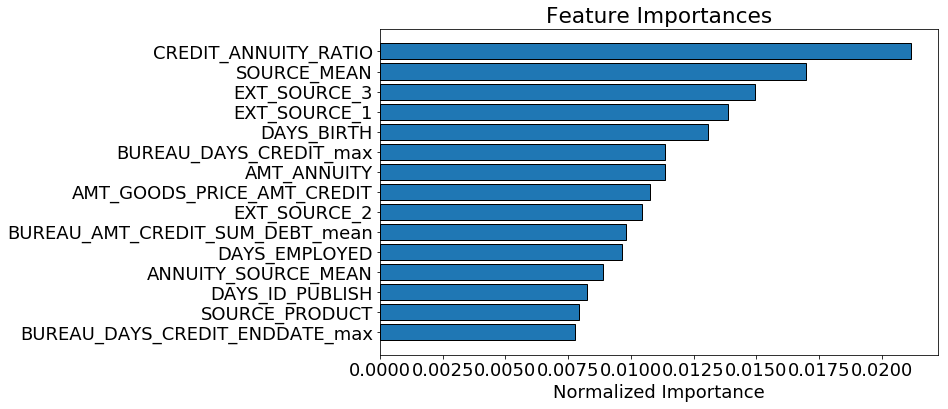

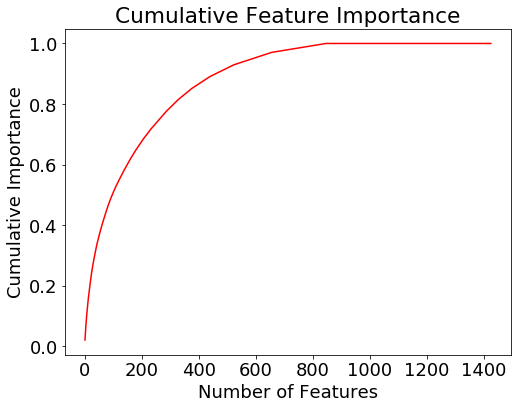

460 features required for 0.90 of cumulative importance


,index,feature,importance,importance_normalized,cumulative_importance
0,241,CREDIT_ANNUITY_RATIO,136,0.021184,0.021184
1,246,SOURCE_MEAN,109,0.016978,0.038162
2,29,EXT_SOURCE_3,96,0.014953,0.053115
3,27,EXT_SOURCE_1,89,0.013863,0.066978
4,6,DAYS_BIRTH,84,0.013084,0.080062
5,262,BUREAU_DAYS_CREDIT_max,73,0.011371,0.091433
6,3,AMT_ANNUITY,73,0.011371,0.102804
7,249,AMT_GOODS_PRICE_AMT_CREDIT,69,0.010748,0.113551
8,28,EXT_SOURCE_2,67,0.010436,0.123988
9,343,BUREAU_AMT_CREDIT_SUM_DEBT_mean,63,0.009813,0.133801


In [101]:
norm_fi = plot_feature_importances(fi)
norm_fi.head(10)

These results should give us confidence that our feature engineering was worthwhile. The ROC AUC on cross validation increase significantly, and a number of the most important features in the model were created by hand. 

In [105]:
zero_features = fi.loc[fi['importance'] == 0.0, 'feature'].copy()
print('There are {} features with 0.0 importance.'.format(len(zero_features)))

There are 580 features with 0.0 importance.


In [115]:
new_features = [x for x in app.columns if x not in original_features]
original_zero = [x for x in original_features if x in zero_features.values]
new_zero = [x for x in new_features if x in zero_features.values]

In [119]:
print('{:.1f}% of the original features have zero importance.'.format(100 * (len(original_zero) / len(original_features))))
print('{:.1f}% of the new features have zero importance.'.format(100 * (len(new_zero) / len(new_features))))

42.6% of the original features have zero importance.
40.2% of the new features have zero importance.


# Conclusions and Next Steps

In this notebook, we implemented a complete manual feature engineering workflow. This involved making features based on several methods:

* Using domain knowledge, either from experts, or from other data scientists who have worked on the problem
* Based on modeling results, by building new features on top of those considered most important by a model
* Grouping and aggregating numeric varaibles in a children dataframe for each parent observation
* Encoding, grouping, and aggregating categorical variables in a child dataframe for each parent observation
* Applying the above two actions multiple times to grandchild dataframes in order to aggregate data at the grandparent level

The final three methods are "naive" in that they don't consider the physical meaning of the created features. The idea is to capture as much information as possible from all the sources of data. This process could also be aided by domain knowledge which would require further expertise and a greater time investment. 

From here, we want to tune the hyperparameters of the Gradient Boosting Machine. Particularly when we have many features, the hyperparameter values can significantly affect the performance of a machine learning model. Hyperparameter tuning can be done in many ways including random search (grid search as well but this is inefficient), Bayesian methods, genetic programming, and gradient-based methods. 